# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Daten laden und vorverarbeiten

In [2]:
#get the data
train = pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train.csv')
test = pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test.csv')

In [3]:
#Modify the Id such that each Id is the full image path. In the form
def train_id_to_path(x):
    return '/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train/' + x + ".jpg"
def test_id_to_path(x):
    return '/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test/' + x + ".jpg"

#Read in the data and drop unnecessary columns
train = pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/train.csv')
train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

test = pd.read_csv('/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/Praktikum/input/test.csv')
test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

#Add the .jpg extensions to the image file name ids
train["img_path"] = train["Id"].apply(train_id_to_path)
test["img_path"] = test["Id"].apply(test_id_to_path)

In [4]:
train

,Id,Pawpularity,img_path
0,0007de18844b0dbbb5e1f607da0606e0,63,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
1,0009c66b9439883ba2750fb825e1d7db,42,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
2,0013fd999caf9a3efe1352ca1b0d937e,28,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
3,0018df346ac9c1d8413cfcc888ca8246,15,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
4,001dc955e10590d3ca4673f034feeef2,72,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,15,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
9908,ffcc8532d76436fc79e50eb2e5238e45,70,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
9909,ffdf2e8673a1da6fb80342fa3b119a20,20,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...
9910,fff19e2ce11718548fa1c5d039a5192a,20,/Users/hoahuynh/Downloads/MA_1.Semester/3-ML/P...


In [5]:
#Set the size image you want to use
image_height = 128
image_width = 128

#define a function that accepts an image url and outputs an eager tensor
def path_to_eagertensor(image_path):
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(raw, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.resize_with_pad(image, image_height, image_width) #optional with padding to retain original dimensions
    image = tf.image.resize(image, (image_height, image_width))
    return image

#get all the images in the training folder and put their tensors in a list
X = []
for img in train['img_path']:
    new_img_tensor = path_to_eagertensor(img)
    X.append(new_img_tensor)
    
print(type(X),len(X))
X = np.array(X)
print(type(X),X.shape)

Metal device set to: Apple M1 Pro


2023-03-02 20:32:56.863794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-02 20:32:56.863941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<class 'list'> 9912
<class 'numpy.ndarray'> (9912, 128, 128, 3)


In [6]:
#grab the target variable. In our case, Pawpularity
y = train['Pawpularity']
print(type(y))

<class 'pandas.core.series.Series'>


In [7]:
#generate train - test splits  90% train - 10% test
#You usually don't want to do a 90-10 split unless you have a lot of data, 
#but we get to evaluate performance using the leaderboard submissions as well
#So I really want this model to see as many pets as possible in trianing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

#Show the shape of each of the new arrays
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7929, 128, 128, 3) (1983, 128, 128, 3) (7929,) (1983,)


# Ein Self-Training-Modell erstellen

In [8]:
#define the inputs to your model. Basically the shape of the incoming data
inputs = tf.keras.Input(shape=(image_height,image_width,3))

#start off with x just being those inputs
x = inputs

x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (7,7), strides = (2,2), padding='valid', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3),padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = "relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs = inputs, outputs = output)

In [9]:
#model.summary()

# Training mit Verlustfunktion "mse"

In [10]:
#compile the model
model.compile(
    loss = 'mse', 
    optimizer ='Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae"])

In [11]:
#you can use this to provide your model with different variations of the same images. 
# It doesn't actually make and save a bunch of new images, just defines how new images can be created. 
# These transformations will randomly be applied to the training images as they get used in training.
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")

history = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=32),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 32,
    epochs = 20
)

Epoch 1/20


2023-03-02 20:36:18.627237: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-02 20:36:19.389647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - ETA: 0s - loss: 494.5014 - rmse: 22.2318 - mae: 16.6484

2023-03-02 20:36:38.081749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - 21s 76ms/step - loss: 494.5014 - rmse: 22.2318 - mae: 16.6484 - val_loss: 714.1658 - val_rmse: 26.7192 - val_mae: 19.0722
Epoch 2/20
247/247 [==============================] - 17s 68ms/step - loss: 446.6906 - rmse: 21.1291 - mae: 15.8209 - val_loss: 500.2128 - val_rmse: 22.3597 - val_mae: 15.3940
Epoch 3/20
247/247 [==============================] - 17s 68ms/step - loss: 440.8935 - rmse: 20.9914 - mae: 15.7085 - val_loss: 487.3049 - val_rmse: 22.0691 - val_mae: 15.3034
Epoch 4/20
247/247 [==============================] - 17s 68ms/step - loss: 438.0722 - rmse: 20.9240 - mae: 15.6363 - val_loss: 582.7567 - val_rmse: 24.1349 - val_mae: 16.5560
Epoch 5/20
247/247 [==============================] - 17s 68ms/step - loss: 439.0578 - rmse: 20.9474 - mae: 15.6814 - val_loss: 467.9944 - val_rmse: 21.6270 - val_mae: 15.1349
Epoch 6/20
247/247 [==============================] - 17s 70ms/step - loss: 434.0473 - rmse: 20.8274 - mae: 15.5781 - val_loss: 476

# Model evaluieren

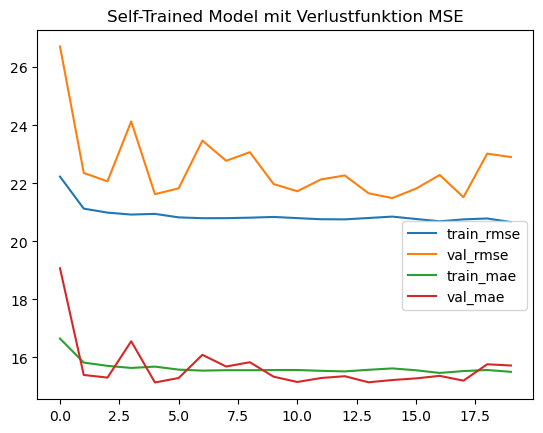

In [12]:
plt.figure()
plt.title("Self-Trained Model mit Verlustfunktion MSE")

plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.plot(history.history["mae"], label="train_mae")
plt.plot(history.history["val_mae"], label="val_mae")

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.savefig('1_Self-Trained_Model_mit_Verlustfunktion_MSE.png')
plt.show()

# Training mit Verlustfunktion "mae"

In [13]:
#compile the model
model.compile(
    loss = 'mae', 
    optimizer ='Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse"), "mae"])

In [14]:
#you can use this to provide your model with different variations of the same images. 
# It doesn't actually make and save a bunch of new images, just defines how new images can be created. 
# These transformations will randomly be applied to the training images as they get used in training.
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    zoom_range = 0.15,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.1,
    horizontal_flip = True, 
    fill_mode = "nearest")

history2 = model.fit(
    data_augmentation.flow(x_train,y_train,batch_size=32),
    validation_data = (x_test,y_test),
    steps_per_epoch = len(x_train) // 32,
    epochs = 20
)

Epoch 1/20


2023-03-02 20:42:00.236690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - ETA: 0s - loss: 15.3905 - rmse: 21.2988 - mae: 15.0757

2023-03-02 20:42:17.731970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


247/247 [==============================] - 20s 73ms/step - loss: 15.3905 - rmse: 21.2988 - mae: 15.0757 - val_loss: 16.6606 - val_rmse: 23.8446 - val_mae: 16.3585
Epoch 2/20
247/247 [==============================] - 17s 68ms/step - loss: 15.3256 - rmse: 21.2607 - mae: 15.0300 - val_loss: 20.7682 - val_rmse: 28.0430 - val_mae: 20.4777
Epoch 3/20
247/247 [==============================] - 17s 67ms/step - loss: 15.3312 - rmse: 21.2856 - mae: 15.0446 - val_loss: 16.6971 - val_rmse: 23.9107 - val_mae: 16.4150
Epoch 4/20
247/247 [==============================] - 17s 67ms/step - loss: 15.3050 - rmse: 21.2732 - mae: 15.0277 - val_loss: 16.2766 - val_rmse: 23.3689 - val_mae: 16.0044
Epoch 5/20
247/247 [==============================] - 17s 67ms/step - loss: 15.2660 - rmse: 21.2745 - mae: 14.9993 - val_loss: 16.9075 - val_rmse: 24.1749 - val_mae: 16.6461
Epoch 6/20
247/247 [==============================] - 17s 67ms/step - loss: 15.3265 - rmse: 21.3469 - mae: 15.0706 - val_loss: 16.2938 - val_

# Model erneut evaluieren

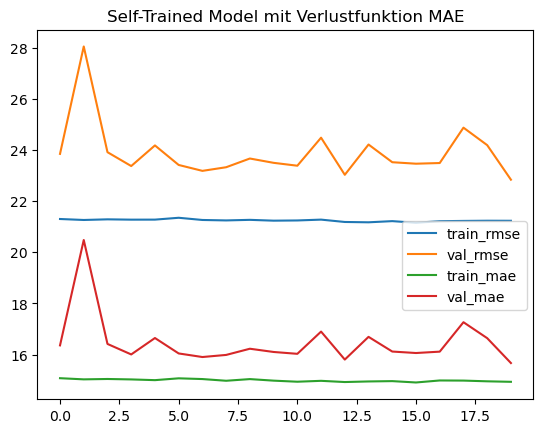

In [15]:
plt.figure()
plt.title("Self-Trained Model mit Verlustfunktion MAE")

plt.plot(history2.history["rmse"], label="train_rmse")
plt.plot(history2.history["val_rmse"], label="val_rmse")
plt.plot(history2.history["mae"], label="train_mae")
plt.plot(history2.history["val_mae"], label="val_mae")

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.savefig('2_Self-Trained_Model_mit_Verlustfunktion_MAE.png')
plt.show()

# Vergleich

/var/folders/7l/64k945l9567573m_x6qrs0_80000gn/T/ipykernel_4644/1039437748.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


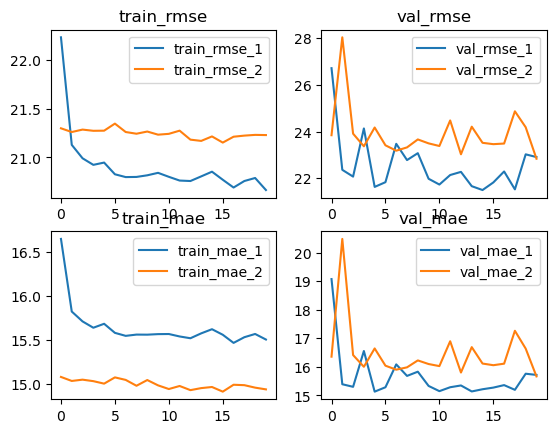

In [16]:
plt.figure()
plt.title("Trainingperformance")

plt.subplot(221)
plt.title('train_rmse')
plt.plot(history.history["rmse"], label="train_rmse_1")
plt.plot(history2.history["rmse"], label="train_rmse_2")
plt.legend()

plt.subplot(222)
plt.title('val_rmse')
plt.plot(history.history["val_rmse"], label="val_rmse_1")
plt.plot(history2.history["val_rmse"], label="val_rmse_2")
plt.legend()

plt.subplot(223)
plt.title('train_mae')
plt.plot(history.history["mae"], label="train_mae_1")
plt.plot(history2.history["mae"], label="train_mae_2")
plt.legend()

plt.subplot(224)
plt.title('val_mae')
plt.plot(history.history["val_mae"], label="val_mae_1")
plt.plot(history2.history["val_mae"], label="val_mae_2")
plt.legend()

plt.savefig('3_Self-Trained_Model_Gesamt.png')
plt.show()